# Predicting Comment Score

In [6]:
import pandas as pd; import numpy as np; 
from scipy.sparse import csr_matrix
import nltk
import math; import time
# import enchant; english_dict = enchant.Dict("en_US")
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
#from html.parser import HTMLParser
from sklearn.cross_validation import StratifiedKFold
from sklearn import linear_model
from sklearn import metrics
# from stemming.porter2 import stem
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, \
                             stop_words = None, max_features = 5000) 

import seaborn
import matplotlib
from matplotlib import pyplot as plt
#from matplotlib import pylab
%matplotlib inline

#%pylab inline
#pylab.rcParams['figure.figsize'] = (20, 5)

# Tsne
from sklearn import manifold

In [7]:
font = {'weight' : 'normal',
        'size'   : 22}

axes = {'titlesize'  : 22,
        'labelsize'  : 22}

legend = {'fontsize'  : 22}

figure = {'figsize'  : (10,5)}

matplotlib.rc('font', **font)
matplotlib.rc('axes', **axes)
matplotlib.rc('legend', **legend)
matplotlib.rc('figure', **figure)

## 1 Data

### 1.1 Import cleaned comments

In [8]:
dft = pd.read_csv("data/finalnbanostop.csv")

In [9]:
#dft_pic = dftrain[dftrain.subreddit=="pics"]
#dft_fun = dftrain[dftrain.subreddit=="funny"]
#dft_gof = dftrain[dftrain.subreddit=="GlobalOffensive"]
#dft_cje = dftrain[dftrain.subreddit=="circlejerk"]
#dft_all = [dft_pic, dft_nba, dft_wne, dft_fun, dft_aww, dft_gof, dft_cje]
dft_wne = dftrain[dftrain.subreddit=="worldnews"]
dft_aww = dftrain[dftrain.subreddit=="aww"]
dft_nba = dftrain[dftrain.subreddit=="nba"]

#dft_all_BOW = [dft_pic_BOW, dft_nba_BOW, dft_wne_BOW, dft_fun_BOW, dft_aww_BOW, dft_gof_BOW, dft_cje_BOW]
#dft_all_TFI = [dft_pic_TFI, dft_nba_TFI, dft_wne_TFI, dft_fun_TFI, dft_aww_TFI, dft_gof_TFI, dft_cje_TFI]

### 1.2 Extract features

In [10]:
dft = dftrain[dftrain.subreddit=="nba"]

In [11]:
# remove nans
def remove_nan(s):
    try:
        f = float(s)
        if math.isnan(f):
            return ""
    except:
        return s
sentences = []
for row in dft['comment']:
    sentences.append(remove_nan(row)) 

In [12]:
print(remove_nan(str(float('nan'))))

In [6]:
# remove more nans
dft = dft[:][(dft['score'].notnull())]
print(sum(dft['score'].isnull()))

0


In [7]:
dft.head()

,Unnamed: 0,Unnamed: 0.1,comment,comment_utc,comment_score,link,title,score,submission_utc,subreddit,submission_id,self_url,body,timedifference
0,0,0,bruh,1.456792e+09,1,http://reddit.com/r/nba/comments/48dhcw/c/d0iqq9r,warriors dominant,0.0,1.456790e+09,nba,48dhcw,https://www.reddit.com/r/nba/comments/48dhcw,NaN,1580.0
1,1,1,go http ftve akamaihd net hls live room k prog u,1.459384e+09,1,http://reddit.com/r/nba/comments/4cnbpg/c/d1jt5ev,game thread los angeles clippers minnesota tim...,25.0,1.459296e+09,nba,4cnbpg,https://www.reddit.com/r/nba/comments/4cnbpg,reddit stream must click link comment page pro...,87579.0
2,2,2,kobe attempts year jason williams attempts yeesh,1.459210e+09,1,http://reddit.com/r/nba/comments/4cbvvd/c/d1h18q2,marcus smart worst point shooting season nba h...,812.0,1.459123e+09,nba,4cbvvd,https://www.reddit.com/r/nba/comments/4cbvvd,NaN,86768.0
3,3,3,sound kinda mean man,1.458174e+09,3,http://reddit.com/r/nba/comments/4aq1y4/c/d12o9bg,game thread oklahoma city thunder boston celti...,49.0,1.458086e+09,nba,4aq1y4,https://www.reddit.com/r/nba/comments/4aq1y4,reddit stream must click link comment page,87423.0
4,4,4,hawks hitting stride gonna tough,1.458605e+09,2,http://reddit.com/r/nba/comments/4beteo/c/d18j7fu,game thread washington wizards atlanta hawks mar,17.0,1.458518e+09,nba,4beteo,https://www.reddit.com/r/nba/comments/4beteo,reddit stream must click link comment page,87059.0


## number of features to use???

What values to use??
occurred in too many documents (max_df): don't need to worry about this one!
occurred in too few documents (min_df): 
were cut off by feature selection (max_features)



In [14]:
# bag of words
vectorizer_count = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None,
                                   stop_words = None, max_features = 5000) 
s_BOW = vectorizer_count.fit_transform(sentences)
print(s_BOW.shape)

(533919, 5000)


In [15]:
# TF_IDF
vectorizer_tfid = TfidfVectorizer(analyzer = "word", tokenizer = None, preprocessor = None,
                                  stop_words = None, max_features = 5000) 
s_TFI = vectorizer_tfid.fit_transform(sentences)

# Visualize bag of words + tf_idf

In [16]:
a_BOW = s_BOW.toarray()
a_TFI = s_TFI.toarray()
print(a_BOW.shape)
print(a_TFI.shape)

(533931, 5000)
(533931, 5000)


To visualize, we need a smaller dataset than .5 million points. We can visualize what this data set looks like by taking a random sample of *200* points


http://scikit-learn.org/stable/auto_examples/manifold/plot_compare_methods.html#example-manifold-plot-compare-methods-py
http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [17]:
bow_small = a_BOW[np.random.randint(low=0,high=a_BOW.shape[0], size=5000), :]
tfi_small = a_TFI[np.random.randint(low=0,high=a_TFI.shape[0], size=5000), :]

# check to make sure (5000,5000)
print(bow_small.shape)

(5000, 5000)


t-SNE: 4.4e+02 sec


(-20.006611770660072,
 43.199085641512454,
 -42.118356903934661,
 15.135454256927639)

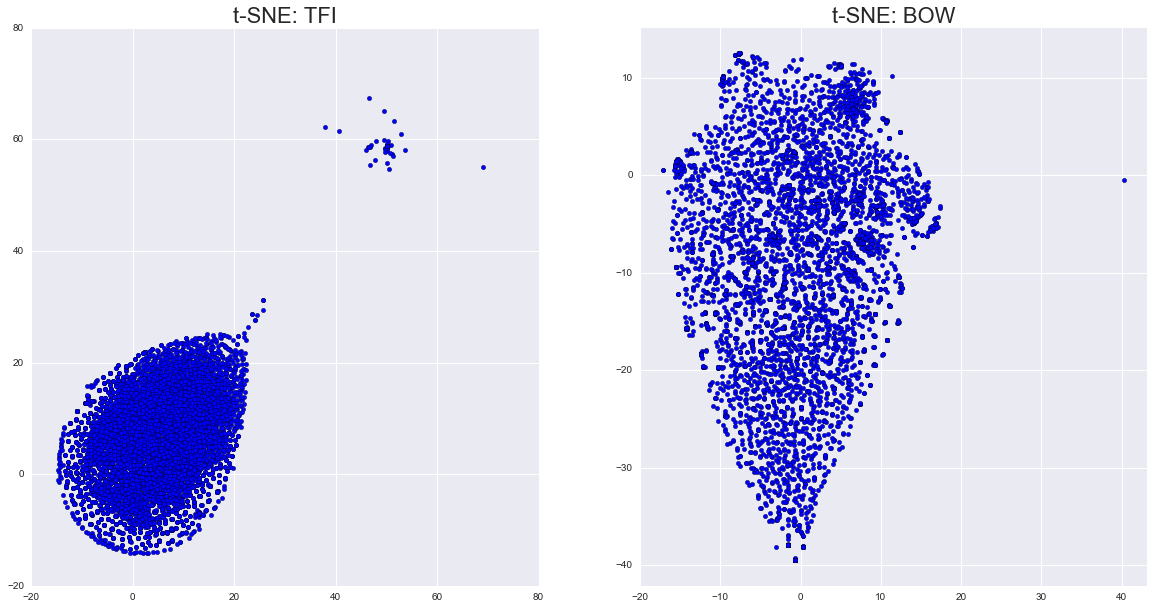

In [18]:
t0 = time.time()

# Perform TSNE
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
Y_tfi = tsne.fit_transform(tfi_small)
Y_bow = tsne.fit_transform(bow_small)

# Print out timing
t1 = time.time()
print("t-SNE: %.2g sec" % (t1 - t0))

# Generate plots
f,ax = plt.subplots(1,2,figsize = (20,10))
ax[0].scatter(Y_tfi[:, 0], Y_tfi[:, 1])#, cmap=plt.cm.Spectral)
ax[0].set_title("t-SNE: TFI")
ax[1].scatter(Y_bow[:, 0], Y_bow[:, 1])#, cmap=plt.cm.Spectral)
ax[1].set_title("t-SNE: BOW")
plt.axis('tight')

In [8]:
# Clean up
del a_BOW, a_TFI, bow_small, tfi_small

NameError: name 'a_BOW' is not defined

In [54]:
dft['comment_score'].describe()

count    533919.000000
mean         10.576288
std          51.107425
min        -457.000000
25%           1.000000
50%           2.000000
75%           6.000000
max        4530.000000
Name: comment_score, dtype: float64

In [55]:
dft['comment_score'].mode()[0]

1

(array([  5.08155000e+05,   2.49670000e+04,   5.85000000e+02,
          1.27000000e+02,   5.40000000e+01,   2.00000000e+01,
          6.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          1.00000000e+00]),
 array([ -457. ,    41.7,   540.4,  1039.1,  1537.8,  2036.5,  2535.2,
         3033.9,  3532.6,  4031.3,  4530. ]),
 <a list of 10 Patch objects>)

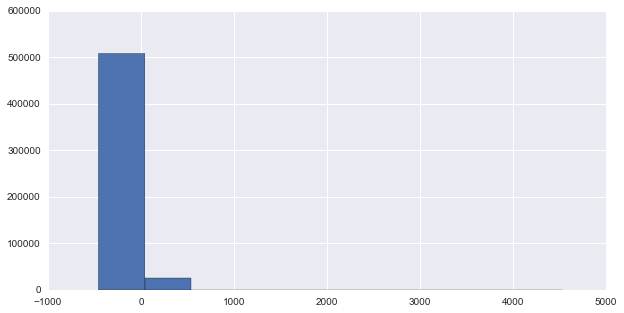

In [56]:
plt.hist(dft['comment_score'])

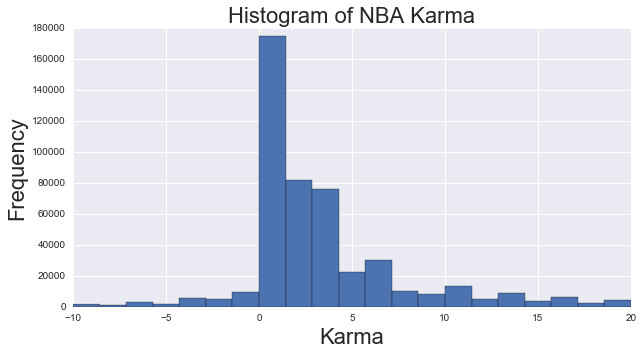

In [57]:
plt.hist(dft['comment_score'],21,range=[-10, 20])
plt.title('Histogram of NBA Karma')
plt.xlabel('Karma')
plt.ylabel('Frequency')

# Clustering

## Regression

1. Remove points [0, 3]
3. Types of regressions

Ridge, Lasso, RF regression, SVR, Linear
CV

Expect RF to be best b/c euclidian distance assumption doesn't work

In [139]:
from scipy.sparse.linalg import svds

In [175]:
# Remove points [0,3]
REMOVE = False
COMPRESS = True

if REMOVE:
    dft_small = dft[(dft['comment_score']<0) | (dft['comment_score']> 3)]
    (ind,) = (np.where((dft['comment_score']<0) | (dft['comment_score']> 3)))
    s_bow_small = s_BOW[ind,:]
    s_tfi_small = s_TFI[ind,:]
else:
    dft_small = dft
    s_bow_small = s_BOW
    s_tfi_small = s_TFI
    
if COMPRESS:
    d = 50
    
    U,S,V = svds(s_tfi_small.T,k=d,which='LM')
    s_tfi_small = s_tfi_small.dot(U)

In [11]:
print(type(s_bow_small), type(s_tfi_small))

(<class 'scipy.sparse.csr.csr_matrix'>, <class 'scipy.sparse.csr.csr_matrix'>)


### Normalize by the score of the post

not doing this!!

In [186]:


#s = np.copy(dft_small['score'])
#s[s==0.0] = 0.1
#a = np.divide(dft_small['comment_score'],s)
#print(max(a), np.percentile(a,.25), np.percentile(a,.5), np.percentile(a,.75))



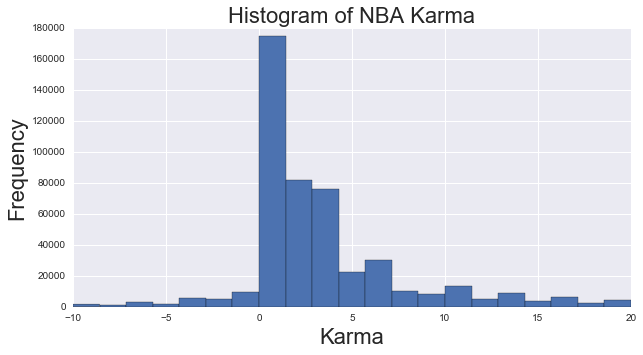

In [14]:
plt.hist(dft_small['comment_score'],bins=21,range=[-10, 20])
if REMOVE:
    plt.title('Histogram of NBA Karma without [0,3]')
else:
    plt.title('Histogram of NBA Karma')
plt.xlabel('Karma')
plt.ylabel('Frequency')

## Regresssion

In [287]:
ltype = 'TFI'

In [187]:
scores = []
for row in dft['comment_score']:
    scores.append((row))
    
scores = np.array(scores)
if REMOVE:
    scores_small = scores[ind]
else:
    scores_small = scores

# there are only 200 ~ score of 200 so set them all to 200
scores_small[scores_small > 200] = 201
scores_small[scores_small < -50] = -51

In [188]:
print(scores_small.shape)

(225821,)


In [15]:
from scipy.sparse import hstack

# Normalize variance
for times

In [194]:
def norm_feature(train, test):
    var = np.var(train)
    mean = np.mean(train)
    
    train[np.isnan(train)] = 0
    test[np.isnan(test)] = 0
    
    train = np.reshape((train-mean)/var, (len(train),1))
    test = np.reshape((test-mean)/var,(len(test),1))
    return(train, test, var, mean)

In [ ]:
# Dimensionality reduction on s_bow_small

In [195]:
k = 10
skf = StratifiedKFold(scores_small,n_folds=k, shuffle=True)

for train_i,test_i in skf:
    if ltype == 'BOW':
        X_val = s_bow_small[test_i,:]
        X = s_bow_small[train_i,:]
    elif ltype == 'TFI':
        X_val = s_tfi_small[test_i,:]
        X = s_tfi_small[train_i,:]
    
    time_ind_val = dft['timedifference'][test_i]
    time_ind = dft['timedifference'][train_i]
    score_ind_val = dft['score'][test_i]
    score_ind = dft['score'][train_i]
        
    Y_val = scores_small[test_i]
    Y = scores_small[train_i]
    break;
    
(score_ind, score_ind_val,_,_) = norm_feature(score_ind, score_ind_val)
(time_ind, time_ind_val,_,_) = norm_feature(time_ind, time_ind_val)


X_val = csr_matrix(hstack((X_val, time_ind_val,score_ind_val)))
X = csr_matrix(hstack((X, time_ind,score_ind)))
print(X_val.shape, X.shape)

((22690, 5002), (203131, 5002))


# MAKE SMALL DATASET FOR NOW!!!

In [196]:
X = X_val
Y = Y_val

In [84]:
from sklearn import linear_model
from sklearn import tree
from sklearn import svm
from sklearn import kernel_ridge
from sklearn import ensemble

In [ ]:
# Ridge, Lasso, RF regression, SVR, Linear
models = {#"Linear":linear_model.LinearRegression(normalize=True),
          #"Ridge": linear_model.Ridge(alpha = 0.5, fit_intercept=True, normalize=True),
          "LassoCV": linear_model.Lasso(alpha = 0.5,fit_intercept=True, normalize=True,
                                      selection='random',max_iter=1000), 
          "SVR": svm.LinearSVR(),
          #"Gradesc": linear_model.SGDRegressor(penalty="l1",n_iter=15),
          "DTree": tree.DecisionTreeRegressor(max_depth=40), 
          "RF": ensemble.RandomForestRegressor(max_depth=40,n_estimators=16)
          #"B.Ridge": linear_model.BayesianRidge(),
          #"ABoost": ensemble.AdaBoostRegressor(),
          }

k = 10
skf = StratifiedKFold(Y,n_folds=k, shuffle=True)

mse = {}
runtimes = {}
for name in models.keys():
    mse[name] = np.empty((k,))
    runtimes[name] = np.empty((k,))

i = 0
alphas = np.linspace(0.005,.4,5)
print('Trial\t\t'+'\t\t'.join(models.keys()))


for train_i, test_i in skf:

    print(i)
    
    X_train, X_test = X[train_i,:],X[test_i,:]
    Y_train, Y_test = Y[train_i], Y[test_i]
        
    for name,model in models.iteritems():
        start_time = time.time()
        
        if name == 'Lasso' or name == 'Ridge':
            print('alpha = %1.3f' % alphas[i])
            model.set_params(alpha = alphas[i])
                
        if name == 'LassoCV' or name == 'RidgeCV':
            cv_mse = np.empty((len(alphas),))
            for a_i,a in enumerate(alphas):
                model.set_params(alpha = a)
                fitted_model = model.fit(X_train,Y_train)
                Y_pred = fitted_model.predict(X_test)
                cv_mse[a_i] = metrics.mean_squared_error(Y_test, Y_pred)
            min_i = np.where(cv_mse==min(cv_mse))[0][0]
            print(name + (' alpha = %1.3f' % alphas[min_i]))
            model.set_params(alpha=alphas[min_i])
        
        fitted_model = model.fit(X_train, Y_train)            

        Y_pred = fitted_model.predict(X_test)
        tim = time.time() - start_time
        runtimes[name][i] = tim
        mse[name][i] = metrics.mean_squared_error(Y_test, Y_pred)
    

    mse_print = 'MSE\t\t'
    time_print = 'Time\t\t'
    for name in models.keys():
        mse_print = mse_print + format('%1.3f'%mse[name][i])+"\t" 
        time_print = time_print + format('%1.3f'%runtimes[name][i]) + "\t\t"
    print(mse_print)
    print(time_print)
    i = i+1
    
    

In [ ]:
for name in models.keys():
    plt.plot(mse[name],label=name)
plt.title('MSE')
plt.xlabel('Index')
plt.ylabel('MSE')
plt.ylim([0,4])
plt.legend()

## Take a look at a specific one

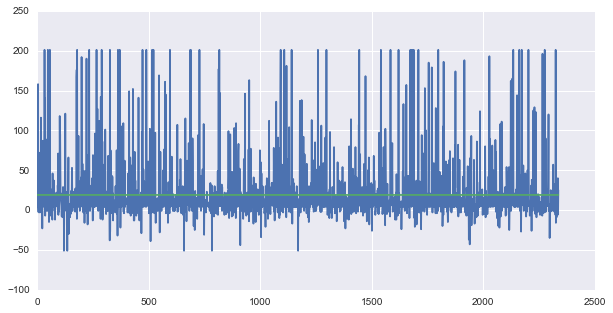

In [218]:
for train_i, test_i in skf:
    X_train, X_test = X[train_i,:],X[test_i,:]
    Y_train, Y_test = Y[train_i], Y[test_i]
    
    model = linear_model.Lasso(alpha=0.261, fit_intercept=True, normalize=True,
                                          selection='random',max_iter=1000)
    fitted_model = model.fit(X_train, Y_train)
    Y_pred = fitted_model.predict(X_test)
    break
plt.plot(Y_test)
plt.plot(Y_pred)

In [219]:
print(np.percentile(Y_pred,.25),np.percentile(Y_pred,.5),np.percentile(Y_pred,.75))

(18.994546258536825, 18.994546258536825, 18.994546258536825)


# Classification

Note: we will set the following boundaries according to score:

Bad: <= 0

Neutral: 1

Good: 2, 3, 4

Very Good: >= 5

In [177]:
# categorize each comment by score
def categorize(score):
    if score<=-5:
        return -2
    elif score>-5 and score < -1:
        return -1
    elif score >= -1 and score <= 2:
        return 0
    elif score >= 2 and score < 10:
        return 1
    elif score >= 10:# and score <=100:
        return 2
#    else:
#        return 3

In [178]:
ltype = 'TFI'

In [179]:
labels = []
for row in dft['comment_score']:
    labels.append(categorize(row))
labels = np.array(labels)
if REMOVE:
    labels_small = labels[ind]
else:
    labels_small = labels

In [180]:
def norm_class_feature(train, test):
    """Noramlization of a feature for classifiers
    Features must be non negative!"""
    #var = np.var(train)
    #mean = np.mean(train)
    
    train[np.isnan(train)] = 0
    test[np.isnan(test)] = 0
    
    #train = (train-mean)/var
    #train = (train-min(train))/(max(train)-min(train))
    #test = (test-mean)/var
    #test = (test-min(test))/(max(test)-min(test))
    
    train = np.reshape(train, (len(train),1))
    test = np.reshape(test,(len(test),1))
    return(train, test)#, var, mean)

In [185]:
from scipy.sparse import hstack

In [191]:
k = 10
skf = StratifiedKFold(labels_small,n_folds=k, shuffle=True)

for train_i,test_i in skf:
    if ltype == 'BOW':
        X_val = s_bow_small[test_i,:]
        X = s_bow_small[train_i,:]
    elif ltype == 'TFI':
        X_val = s_tfi_small[test_i,:]
        X = s_tfi_small[train_i,:]
    
    time_ind_val = dft['timedifference'][test_i]
    time_ind = dft['timedifference'][train_i]
    score_ind_val = dft['score'][test_i]
    score_ind = dft['score'][train_i]
        
    Y_val = labels_small[test_i]
    Y = labels_small[train_i]
    break;
    
(score_ind, score_ind_val) = norm_class_feature(score_ind, score_ind_val)
(time_ind, time_ind_val) = norm_class_feature(time_ind, time_ind_val)


X_val = csr_matrix(np.concatenate((X_val, time_ind_val,score_ind_val),axis=1))
X = csr_matrix(np.concatenate((X, time_ind,score_ind),axis=1))
print(X_val.shape, X.shape)

((53375, 52), (480347, 52))


In [193]:
# TAKE 10% OF DATA!!!
X = X_val
Y = Y_val

# Take an equal amount from each section

ind = np.array([])
for i in range(-2,3):
    ind = np.concatenate((ind,np.random.choice(np.where(Y==i)[0], size = 10000)))
    ind = [int(x) for x in ind]

X = X[ind,:]
Y = Y[ind]

In [194]:
print(sum([Y==3][0]), sum([Y==2][0]), sum([Y==1][0]),sum([Y==0][0]),sum([Y==-1][0]), sum([Y==-2][0]))

(0, 10000, 10000, 10000, 10000, 10000)


In [195]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [198]:
nNeighbors = 10 #KNN
maxLearners = 100 #RF
maxDepth = 10 #RF
models = {#"MNB": MultinomialNB(),
#           "KNN": KNeighborsClassifier(n_neighbors=nNeighbors), 
          #"LSV": LinearSVC(), 
          #"DFT": DecisionTreeClassifier(), 
          #"RFC": RandomForestClassifier(n_estimators=maxLearners, max_depth = maxDepth, warm_start = False), 
          "LOR": LogisticRegression(),
          }

In [199]:
k = 10
skf = StratifiedKFold(Y,n_folds=k, shuffle=True)

#nNeighbors = np.range(3,20,)

accuracies = {}
f1scores = {}
precisions = {}
recalls = {}
runtimes = {}
for name in models.keys():
    accuracies[name] = np.empty((k,))
    f1scores[name] = np.empty((k,))
    precisions[name] = np.empty((k,))
    recalls[name] = np.empty((k,))
    runtimes[name] = np.empty((k,))
    
print('Trial\t\t'+'\t\t'.join(models.keys()))

i = 0

for train_i, test_i in skf:
    print(i)
    X_train, X_test = X[train_i,:],X[test_i,:]
    Y_train, Y_test = Y[train_i], Y[test_i]
        
    for name,model in models.iteritems():
        start_time = time.time()
        
#        if name == 'KNN':

#            model.n_neighbors = 
        fitted_model = model.fit(X_train, Y_train)
        Y_pred = fitted_model.predict(X_test)
        tim = time.time() - start_time
        
        accuracies[name][i] = metrics.accuracy_score(Y_test, Y_pred)
        f1scores[name][i] = metrics.f1_score(Y_test, Y_pred,average='weighted')
        precisions[name][i] = metrics.precision_score(Y_test, Y_pred,average='weighted')
        recalls[name][i] = metrics.recall_score(Y_test, Y_pred,average='weighted')
        runtimes[name][i] = tim
    
    ac_print = 'AC'
    f1scores_print = 'F1'
    precisions_print = 'Prec'
    recalls_print = 'Recall'
    time_print = 'Time'
    for name in models.keys():
        ac_print = ac_print + "\t\t" + format('%1.3f'%accuracies[name][i])
        f1scores_print = f1scores_print + "\t\t" + format('%1.3f'%f1scores[name][i])
        precisions_print = precisions_print + "\t\t" + format('%1.3f'%precisions[name][i])
        recalls_print = recalls_print + "\t\t" + format('%1.3f'%recalls[name][i])
        time_print = time_print + "\t\t" + format('%1.3f'%runtimes[name][i])
    print(ac_print)
    print(f1scores_print)
    print(precisions_print)
    print(recalls_print)
    print(time_print)
    
    i = i+1


Trial		LOR
0
AC		0.200
F1		0.114
Prec		0.117
Recall		0.200
Time		1.226
1
AC		0.193
F1		0.118
Prec		0.118
Recall		0.193
Time		1.075
2
AC		0.204
F1		0.099
Prec		0.106
Recall		0.204
Time		1.111
3
AC		0.200
F1		0.099
Prec		0.078
Recall		0.200
Time		1.082
4
AC		0.200
F1		0.104
Prec		0.117
Recall		0.200
Time		1.105
5
AC		0.203
F1		0.143
Prec		0.123
Recall		0.203
Time		1.072
6
AC		0.197
F1		0.115
Prec		0.116
Recall		0.197
Time		1.071
7
AC		0.192
F1		0.134
Prec		0.114
Recall		0.192
Time		1.056
8
AC		0.202
F1		0.101
Prec		0.082
Recall		0.202
Time		1.081
9
AC		0.194
F1		0.095
Prec		0.075
Recall		0.194
Time		1.208


In [125]:
print('Means')
for name in models.keys():
    print(name+(' AC %1.3f\tF1: %1.3f\tPrecision: %1.3f\tRecall: %1.3f\t Time: %1.3f\t'
          %(np.mean(accuracies[name]),np.mean(f1scores[name]),np.mean(precisions[name]),
            np.mean(recalls[name]),np.mean(runtimes[name]))))

Means
LOR AC 0.206	F1: 0.114	Precision: 0.092	Recall: 0.206	 Time: 0.058	
MNB AC 0.206	F1: 0.141	Precision: 0.240	Recall: 0.206	 Time: 0.002	


In [ ]:
from sklearn import svm, datasets
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear', C=0.01)
y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(iris.target_names))
    plt.xticks(tick_marks, iris.target_names, rotation=45)
    plt.yticks(tick_marks, iris.target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()